# Hockey IAR (Impact Above Replacement) — 2024–25 Proof of Concept (5v5-first + Modular Special Teams)

This project builds a transparent, reproducible “WAR-like” metric for hockey using publicly available 2024–25 data. The goal is to estimate a player’s Impact Above Replacement (IAR) in a way that is intuitive for decision-making and easy to audit end-to-end.

## Why IAR (and why “5v5-first”)?
Hockey is continuous and highly context-dependent, so simple box-score totals miss a lot of value. This metric starts with 5v5 as the core signal (the cleanest and most comparable environment), then adds Power Play (5v4) and Penalty Kill (4v5) as separate modules. This keeps interpretation clear (special teams roles differ widely) while still allowing an all-situations total when needed.

## Data used (public)
This notebook uses 2024–25 season tables derived from public MoneyPuck outputs, with the exception of Contracts data:
- `skaters.csv` — on-ice and off-ice expected-goals components and ice time by situation  
- `teams.csv` — team-level ice time by situation (used to correctly compute off-ice denominators)  
- `lines.csv` — line-level segments (reserved for future upgrades controlling for teammate effects)  
- `goalies.csv` — goalie xG and goals allowed by situation  
- `contracts.csv` — public contract information (AAV) for cost/value features (From Kaggle)

## Method overview (skaters)
For each skater and each situation (5v5 / PP / PK):

1. **On-ice xG differential:**  
   \[
   xG_{on} = xG^{for}_{on} - xG^{against}_{on}
   \]

2. **Off-ice xG differential (team without the player):**  
   \[
   xG_{off} = xG^{for}_{off} - xG^{against}_{off}
   \]

3. Convert both to **per-60 rates** using ice time in seconds, then compute the player’s **on/off impact rate**:  
   \[
   ImpactRate = Rate_{on} - Rate_{off}
   \]

4. Convert back to a **total impact** over the player’s minutes in that situation.

5. Subtract a **replacement baseline** (Proof of concept: a position-group baseline using the 20th percentile of impact rates among regulars, split F vs D).

6. Convert impact to **wins** using a tunable constant (goals-per-win proxy), producing:
- `IAR_5v5`, `IAR_PP`, `IAR_PK` (each in wins)
- `IAR_total = IAR_5v5 + IAR_PP + IAR_PK`

## Method overview (goalies)
For goalies, impact is based on a simple **goals-saved-above-expected** concept:
\[
GSAx = xG - GA
\]
This is converted to wins and baselined against a replacement threshold (same spirit as skaters).

## Outputs
The notebook produces:
- **Leaderboards** (best/worst) for skaters and goalies with minimum TOI thresholds to reduce small-sample noise
- **Modular breakdown** (5v5 / PP / PK) plus `IAR_total`
- **Cost/value features** by merging contracts:
  - `IAR_total_per_M` = IAR wins per $1M AAV (useful for “value” identification; interpreted with caution for ELCs)

## Important notes / limitations (intentional for a POC)
- This is an **on/off** model and will still reflect **teammate and deployment effects** to some degree.
- The next planned upgrade is a **ridge/RAPM-lite** approach using `lines.csv` to better control for linemates (while preserving the same 5v5-first + modular framework).

## Why this belongs in an NHL analytics portfolio
This project demonstrates:
- End-to-end feature engineering on real hockey data
- Careful metric design and interpretability
- Modular modeling choices aligned with how teams evaluate players (5v5 core + special teams context)
- A clear path to more rigorous causal attribution (line/shift-level regression extensions)

In [44]:
import os
import re
import zipfile
from io import BytesIO
import requests
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import re
import unicodedata
import plotly.express as px
import plotly.graph_objects as go


# Importing Data

In [9]:
contracts = pd.read_csv(r"/Users/tylerroberts/Library/CloudStorage/OneDrive-HomewardTrustEdmonton/Documents/Projects/Side/WAR Modelling/contracts.csv")
print(f"Contracts shape: {contracts.shape}")

goalies = pd.read_csv(r"/Users/tylerroberts/Library/CloudStorage/OneDrive-HomewardTrustEdmonton/Documents/Projects/Side/WAR Modelling/goalies.csv")
print(f"Goalies shape: {goalies.shape}")


skaters = pd.read_csv(r"/Users/tylerroberts/Library/CloudStorage/OneDrive-HomewardTrustEdmonton/Documents/Projects/Side/WAR Modelling/skaters.csv")
print(f"Skaters shape: {skaters.shape}")


lines = pd.read_csv(r"/Users/tylerroberts/Library/CloudStorage/OneDrive-HomewardTrustEdmonton/Documents/Projects/Side/WAR Modelling/lines.csv")
print(f"Lines shape: {lines.shape}")


teams = pd.read_csv(r"/Users/tylerroberts/Library/CloudStorage/OneDrive-HomewardTrustEdmonton/Documents/Projects/Side/WAR Modelling/teams.csv")
print(f"Teams shape: {teams.shape}")



Contracts shape: (1139, 40)
Goalies shape: (515, 36)
Skaters shape: (4600, 154)
Lines shape: (3056, 108)
Teams shape: (160, 107)


# Parameter Definition

In [12]:
# Defining season
SEASON = 2024

# Modular situations (MoneyPuck naming)
SITUATIONS = {
    "5v5": "5on5",
    "PP":  "5on4",  # power play for skaters, but for goalies it's "when their team is on PP"
    "PK":  "4on5",  # penalty kill for skaters
}

# Convert xG-like units to wins (Proof of concept constant; tune later)
GOALS_PER_WIN = 6.0

# Leaderboard filters (avoid tiny-sample “worst” lists)
MIN_SKATER_5V5_MIN = 600
MIN_GOALIE_5V5_MIN = 600



# Helper Functions

In [15]:
# Name cleaning
def norm_name(s: str) -> str:
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.lower()
    s = re.sub(r"[^a-z0-9 ]+", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Money
def parse_money(x):
    if pd.isna(x):
        return np.nan
    s = str(x).replace("$", "").replace(",", "").strip()
    try:
        return float(s)
    except Exception:
        return np.nan



# Contracts: 
- Collapse duplicates (trades) -> 1 row per player name_key

In [18]:
# Cleaninhg
contracts["name_key"] = contracts["Player.ascii"].map(norm_name)
contracts["AAV_num"]  = contracts["AAV"].map(parse_money)

C = (
    contracts
    .sort_values(["name_key", "GP"], ascending=[True, False])
    .groupby("name_key", as_index=False)
    .agg({
        "AAV_num": "max",
        "Length": "max",
        "Value": "max",
        "Pos.grouped": "first",
        "Age": "max",
        "Team": lambda s: ",".join(sorted(set(s.dropna().astype(str))))
    })
)

C.head()

,name_key,AAV_num,Length,Value,Pos.grouped,Age,Team
0,aaron ekblad,6100000.0,8,"$48,800,000",D,28.0,Florida Panthers
1,aatu raty,775000.0,2,"$1,550,000",F,22.0,Vancouver Canucks
2,adam boqvist,850000.0,1,"$850,000",D,24.0,"Florida Panthers,New York islanders"
3,adam edstrom,975000.0,2,"$1,950,000",F,24.0,New York Rangers
4,adam fantilli,950000.0,3,"$2,850,000",F,20.0,Columbus Blue Jackets


# Skater IAR component builder


In [21]:

def skater_component(sit_code: str, min_minutes_for_rep: int) -> pd.DataFrame:
    """
    Computes an on/off impact for a single situation and converts to IAR_wins.
    Replacement is a 20th percentile impact_rate within F vs D (Proof of concept).
    """
    T = (
        teams.query("season == @SEASON and situation == @sit_code")[["team", "season", "situation", "iceTime"]]
        .copy()
    )
    S = skaters.query("season == @SEASON and situation == @sit_code").copy()
    S = S.merge(T, on=["team", "season", "situation"], how="left", validate="m:1")

    # Prefer adjusted on-ice xG if present
    F_XG = "OnIce_F_scoreVenueAdjustedxGoals" if "OnIce_F_scoreVenueAdjustedxGoals" in S.columns else "OnIce_F_xGoals"
    A_XG = "OnIce_A_scoreVenueAdjustedxGoals" if "OnIce_A_scoreVenueAdjustedxGoals" in S.columns else "OnIce_A_xGoals"

    S["on_sec"]   = S["icetime"].astype(float)
    S["team_sec"] = S["iceTime"].astype(float)
    S["off_sec"]  = (S["team_sec"] - S["on_sec"]).clip(lower=1.0)

    S["on_xg_diff"]  = S[F_XG] - S[A_XG]
    S["off_xg_diff"] = S["OffIce_F_xGoals"] - S["OffIce_A_xGoals"]

    # per-60 rates
    S["on_rate"]  = S["on_xg_diff"]  / S["on_sec"]  * 3600
    S["off_rate"] = S["off_xg_diff"] / S["off_sec"] * 3600

    # on/off delta = impact above teammates
    S["impact_rate"] = S["on_rate"] - S["off_rate"]
    S["impact_xg"]   = S["impact_rate"] * (S["on_sec"] / 3600)

    # Replacement baseline by F vs D
    S["pos_group"] = np.where(S["position"] == "D", "D", "F")
    S["min_on"] = S["on_sec"] / 60

    rep_pool = S[S["min_on"] >= min_minutes_for_rep].copy()
    rep = (
        rep_pool.groupby("pos_group")["impact_rate"]
        .quantile(0.20)
        .rename("rep_rate")
        .reset_index()
    )
    S = S.merge(rep, on="pos_group", how="left")

    S["rep_xg"]   = S["rep_rate"] * (S["on_sec"] / 3600)
    S["IAR_xg"]   = S["impact_xg"] - S["rep_xg"]
    S["IAR_wins"] = S["IAR_xg"] / GOALS_PER_WIN

    # Aggregate across stints / teams (safe by playerId)
    S["name_key"] = S["name"].map(norm_name)
    out = (
        S.groupby(["playerId", "name", "name_key", "pos_group"], as_index=False)
        .agg(
            on_sec=("on_sec", "sum"),
            min_on=("min_on", "sum"),
            IAR_xg=("IAR_xg", "sum"),
            IAR_wins=("IAR_wins", "sum"),
            team=("team", lambda x: ",".join(sorted(set(x)))),
            position=("position", lambda x: ",".join(sorted(set(x)))),
        )
    )
    return out



In [23]:
# Build skater components (thresholds: 5v5 larger than special teams)
sk_5v5 = skater_component(SITUATIONS["5v5"], min_minutes_for_rep=300)
sk_pp  = skater_component(SITUATIONS["PP"],  min_minutes_for_rep=80)
sk_pk  = skater_component(SITUATIONS["PK"],  min_minutes_for_rep=80)

# Merge into modular table
sk = (
    sk_5v5[["playerId", "name", "name_key", "pos_group", "team", "position", "min_on", "IAR_wins"]]
    .rename(columns={"min_on": "min_5v5", "IAR_wins": "IAR_5v5"})
    .merge(
        sk_pp[["playerId", "min_on", "IAR_wins"]].rename(columns={"min_on": "min_PP", "IAR_wins": "IAR_PP"}),
        on="playerId", how="left"
    )
    .merge(
        sk_pk[["playerId", "min_on", "IAR_wins"]].rename(columns={"min_on": "min_PK", "IAR_wins": "IAR_PK"}),
        on="playerId", how="left"
    )
)

sk.head()

,playerId,name,name_key,pos_group,team,position,min_5v5,IAR_5v5,min_PP,IAR_PP,min_PK,IAR_PK
0,8470600,Ryan Suter,ryan suter,D,STL,D,1399.133333,-0.048823,6.466667,-0.023177,158.466667,1.362516
1,8470613,Brent Burns,brent burns,D,CAR,D,1310.400000,1.468199,130.200000,-0.376180,182.583333,2.515780
2,8470621,Corey Perry,corey perry,F,EDM,R,830.750000,0.189983,101.100000,-0.013159,0.000000,0.000000
3,8471214,Alex Ovechkin,alex ovechkin,F,WSH,L,839.066667,-1.047971,259.816667,4.228726,0.950000,-0.033845
4,8471215,Evgeni Malkin,evgeni malkin,F,PIT,C,1003.733333,0.770051,160.383333,0.401496,0.450000,0.003864


In [25]:
for col in ["min_PP", "min_PK", "IAR_PP", "IAR_PK"]:
    sk[col] = sk[col].fillna(0.0)

sk["IAR_total"] = sk["IAR_5v5"] + sk["IAR_PP"] + sk["IAR_PK"]

# Attach contracts and value metrics
sk = sk.merge(C, on="name_key", how="left")
sk["IAR_total_per_M"] = sk["IAR_total"] / (sk["AAV_num"] / 1e6)
sk["IAR_5v5_per_M"]   = sk["IAR_5v5"]   / (sk["AAV_num"] / 1e6)

sk.head()

,playerId,name,name_key,pos_group,team,position,min_5v5,IAR_5v5,min_PP,IAR_PP,...,IAR_PK,IAR_total,AAV_num,Length,Value,Pos.grouped,Age,Team,IAR_total_per_M,IAR_5v5_per_M
0,8470600,Ryan Suter,ryan suter,D,STL,D,1399.133333,-0.048823,6.466667,-0.023177,...,1.362516,1.290516,775000.0,1.0,"$775,000",D,40.0,St. Louis Blues,1.665182,-0.062997
1,8470613,Brent Burns,brent burns,D,CAR,D,1310.400000,1.468199,130.200000,-0.376180,...,2.515780,3.607800,1000000.0,1.0,"$1,000,000",D,39.0,Carolina Hurricanes,3.607800,1.468199
2,8470621,Corey Perry,corey perry,F,EDM,R,830.750000,0.189983,101.100000,-0.013159,...,0.000000,0.176824,2000000.0,1.0,"$2,000,000",F,39.0,Edmonton Oilers,0.088412,0.094991
3,8471214,Alex Ovechkin,alex ovechkin,F,WSH,L,839.066667,-1.047971,259.816667,4.228726,...,-0.033845,3.146910,9500000.0,5.0,"$47,500,000",F,39.0,Washington Capitals,0.331254,-0.110313
4,8471215,Evgeni Malkin,evgeni malkin,F,PIT,C,1003.733333,0.770051,160.383333,0.401496,...,0.003864,1.175412,6100000.0,4.0,"$24,400,000",F,38.0,Pittsburgh Penguins,0.192690,0.126238


In [27]:
# Debug: unmatched names (helpful for data completeness and cleanup)
unmatched_contracts = (
    sk[sk["AAV_num"].isna()][["name", "team", "position"]]
    .drop_duplicates()
    .sort_values(["team", "name"])
)
unmatched_contracts.head()

,name,team,position
762,Josh Dunne,BUF,C
508,Josh Norris,BUF,C
473,Zachary Aston-Reese,CBJ,C
776,Matt Coronato,CGY,R
21,Patrick Maroon,CHI,L


# Goalie modular IAR (GSAx-style)

In [30]:

def goalie_component(sit_code: str, min_minutes_for_rep: int) -> pd.DataFrame:
    """
    Goalie impact: gsax = xGoals - goals (in xG units), replacement at 20th percentile gsax_rate.
    """
    G = goalies.query("season == @SEASON and situation == @sit_code").copy()
    G["on_sec"] = G["icetime"].astype(float)
    G["min_on"] = G["on_sec"] / 60

    G["gsax"] = G["xGoals"] - G["goals"]
    G["gsax_rate"] = G["gsax"] / G["on_sec"] * 3600

    rep_pool = G[G["min_on"] >= min_minutes_for_rep]
    rep_rate = float(rep_pool["gsax_rate"].quantile(0.20)) if len(rep_pool) else 0.0

    G["rep_gsax"] = rep_rate * (G["on_sec"] / 3600)
    G["IAR_xg"]   = G["gsax"] - G["rep_gsax"]
    G["IAR_wins"] = G["IAR_xg"] / GOALS_PER_WIN

    out = (
        G.groupby(["playerId", "name", "team"], as_index=False)
        .agg(
            min_on=("min_on", "sum"),
            IAR_wins=("IAR_wins", "sum"),
            IAR_xg=("IAR_xg", "sum")
        )
    )
    return out



In [32]:
# Initial calculation of each component
g_5v5 = goalie_component(SITUATIONS["5v5"], min_minutes_for_rep=600).rename(columns={"min_on":"min_5v5","IAR_wins":"IAR_5v5"})
g_pp  = goalie_component(SITUATIONS["PP"],  min_minutes_for_rep=120).rename(columns={"min_on":"min_PP","IAR_wins":"IAR_PP"})
g_pk  = goalie_component(SITUATIONS["PK"],  min_minutes_for_rep=120).rename(columns={"min_on":"min_PK","IAR_wins":"IAR_PK"})

g = (
    g_5v5
    .merge(g_pp[["playerId", "min_PP", "IAR_PP"]], on="playerId", how="left")
    .merge(g_pk[["playerId", "min_PK", "IAR_PK"]], on="playerId", how="left")
)

g.head()


,playerId,name,team,min_5v5,IAR_5v5,IAR_xg,min_PP,IAR_PP,min_PK,IAR_PK
0,8470594,Marc-Andre Fleury,MIN,1171.533333,-0.151714,-0.910284,99.483333,0.098157,82.400000,-0.323109
1,8471734,Jonathan Quick,NYR,1129.850000,0.239646,1.437874,85.016667,-0.067086,74.833333,0.277655
2,8473503,James Reimer,BUF,1125.116667,1.803060,10.818360,96.466667,0.163312,99.416667,0.058891
3,8473575,Semyon Varlamov,NYI,509.866667,0.790326,4.741956,59.250000,0.167431,25.433333,-0.539000
4,8474593,Jacob Markstrom,NJD,2427.216667,0.924391,5.546345,181.600000,0.526349,228.050000,1.547567


In [34]:
for col in ["min_PP", "min_PK", "IAR_PP", "IAR_PK"]:
    g[col] = g[col].fillna(0.0)

# Getting total IAR
g["IAR_total"] = g["IAR_5v5"] + g["IAR_PP"] + g["IAR_PK"]

g.head()

,playerId,name,team,min_5v5,IAR_5v5,IAR_xg,min_PP,IAR_PP,min_PK,IAR_PK,IAR_total
0,8470594,Marc-Andre Fleury,MIN,1171.533333,-0.151714,-0.910284,99.483333,0.098157,82.400000,-0.323109,-0.376666
1,8471734,Jonathan Quick,NYR,1129.850000,0.239646,1.437874,85.016667,-0.067086,74.833333,0.277655,0.450215
2,8473503,James Reimer,BUF,1125.116667,1.803060,10.818360,96.466667,0.163312,99.416667,0.058891,2.025263
3,8473575,Semyon Varlamov,NYI,509.866667,0.790326,4.741956,59.250000,0.167431,25.433333,-0.539000,0.418756
4,8474593,Jacob Markstrom,NJD,2427.216667,0.924391,5.546345,181.600000,0.526349,228.050000,1.547567,2.998307


# Leaderboards: Highest and lowest IAR skaters and goalies


In [37]:
#Skaters
top_skaters = sk[sk["min_5v5"] >= MIN_SKATER_5V5_MIN].sort_values("IAR_total", ascending=False).head(20)
worst_skaters = sk[sk["min_5v5"] >= MIN_SKATER_5V5_MIN].sort_values("IAR_total", ascending=True).head(20)

#Goalies
top_goalies = g[g["min_5v5"] >= MIN_GOALIE_5V5_MIN].sort_values("IAR_total", ascending=False).head(20)
worst_goalies = g[g["min_5v5"] >= MIN_GOALIE_5V5_MIN].sort_values("IAR_total", ascending=True).head(20)

print("\n=== TOP SKATERS (IAR_total) ===")
print(top_skaters[["name","team","position","min_5v5","IAR_5v5","IAR_PP","IAR_PK","IAR_total","AAV_num","IAR_total_per_M"]].to_string(index=False))

print("\n=== WORST SKATERS (IAR_total) ===")
print(worst_skaters[["name","team","position","min_5v5","IAR_5v5","IAR_PP","IAR_PK","IAR_total","AAV_num","IAR_total_per_M"]].to_string(index=False))

print("\n=== TOP GOALIES (IAR_total) ===")
print(top_goalies[["name","team","min_5v5","IAR_5v5","IAR_PP","IAR_PK","IAR_total"]].to_string(index=False))

print("\n=== WORST GOALIES (IAR_total) ===")
print(worst_goalies[["name","team","min_5v5","IAR_5v5","IAR_PP","IAR_PK","IAR_total"]].to_string(index=False))

#Data completeness
print("\n=== CONTRACTS UNMATCHED (sample) ===")
print(f"{unmatched_contracts.shape[0]} unmatched contracts ({round(unmatched_contracts.shape[0]/contracts.shape[0], 2)}%). Review later")




=== TOP SKATERS (IAR_total) ===
            name team position     min_5v5  IAR_5v5    IAR_PP    IAR_PK  IAR_total    AAV_num  IAR_total_per_M
  Leon Draisaitl  EDM        C 1205.316667 5.104742  3.976355  0.054731   9.135827 14000000.0         0.652559
  Connor McDavid  EDM        C 1175.400000 5.185111  3.571812  0.061497   8.818420 12500000.0         0.705474
        Adam Fox  NYR        D 1278.650000 5.426910  3.306290 -0.237276   8.495924  9500000.0         0.894308
Nathan MacKinnon  COL        C 1377.300000 4.906676  3.320954  0.039783   8.267413 12600000.0         0.656144
 Nikita Kucherov  TBL        R 1286.300000 3.133846  4.694419 -0.097398   7.730867  9500000.0         0.813775
     Jack Hughes  NJD        C  970.483333 2.806108  4.177515  0.569741   7.553364  8000000.0         0.944171
    Quinn Hughes  VAN        D 1408.966667 3.937955  3.309202  0.086968   7.334125  7850000.0         0.934283
    Jesper Bratt  NJD        L 1101.283333 1.947366  4.693374  0.531290   7.172

# Exporting Data for Review

In [40]:
# Skaters
sk.to_csv("iar_skaters_2024_poc.csv", index=False)

# Goalies
g.to_csv("iar_goalies_2024_poc.csv", index=False)

In [ ]:
# Adding label columns and merging
sk['position_label'] = 'skater'
g['position_label'] = 'goalie'

# merging
merged_df = pd.merge(sk, g, how='left', left_on='Name', right_on='Name')



## Setup + Top/Bottom 10 selection

In [200]:
# Load your output table
sk = pd.read_csv("iar_skaters_2024_poc.csv")

# Basic cleanup / engineered fields
sk["IAR_ST"] = sk["IAR_PP"].fillna(0) + sk["IAR_PK"].fillna(0)  # special teams
sk["label"] = sk["name"] + " (" + sk["team"].astype(str) + ", " + sk["position"].astype(str) + ")"

# Recommended filter for stable leaderboards
MIN_5V5_MIN = 600
skq = sk[sk["min_5v5"] >= MIN_5V5_MIN].copy()

# Getting only oilers
skq_oilers = skq.loc[skq['team'] == 'EDM']

# Top / bottom 10 by total impact
top10 = skq.nlargest(10, "IAR_total").copy()
bot10 = skq.nsmallest(10, "IAR_total").copy()
top10_oilers = skq_oilers.nlargest(10, "IAR_total").copy()

# Combined set for “top vs bottom” visuals
tb = pd.concat([top10.assign(group="Top 10"), bot10.assign(group="Bottom 10")], ignore_index=True)

# Helpful ordering for plots
top_order = top10.sort_values("IAR_total", ascending=True)["label"].tolist()   # ascending for horizontal bars
bot_order = bot10.sort_values("IAR_total", ascending=True)["label"].tolist()
top_order_oilers = top10_oilers.sort_values("IAR_total", ascending=True)["label"].tolist()   # ascending for horizontal bars


In [202]:
skq_oilers.head()

,playerId,name,name_key,pos_group,team,position,min_5v5,IAR_5v5,min_PP,IAR_PP,...,AAV_num,Length,Value,Pos.grouped,Age,Team,IAR_total_per_M,IAR_5v5_per_M,IAR_ST,label
2,8470621,Corey Perry,corey perry,F,EDM,R,830.750000,0.189983,101.100000,-0.013159,...,2000000.0,1.0,"$2,000,000",F,39.0,Edmonton Oilers,0.088412,0.094991,-0.013159,"Corey Perry (EDM, R)"
44,8474641,Adam Henrique,adam henrique,F,EDM,C,958.100000,-1.211453,68.700000,0.106175,...,3000000.0,2.0,"$6,000,000",F,34.0,Edmonton Oilers,-0.260717,-0.403818,0.429302,"Adam Henrique (EDM, C)"
70,8475218,Mattias Ekholm,mattias ekholm,D,EDM,D,1182.816667,4.310489,57.700000,-0.032338,...,6250000.0,4.0,"$25,000,000",D,34.0,Edmonton Oilers,0.634848,0.689678,-0.342688,"Mattias Ekholm (EDM, D)"
103,8475784,Jeff Skinner,jeff skinner,F,EDM,L,832.516667,0.298101,85.783333,-0.436567,...,3000000.0,1.0,"$3,000,000",F,32.0,Edmonton Oilers,-0.045560,0.099367,-0.434781,"Jeff Skinner (EDM, L)"
104,8475786,Zach Hyman,zach hyman,F,EDM,L,1089.516667,4.532692,221.283333,1.857026,...,5500000.0,7.0,"$38,500,000",F,32.0,Edmonton Oilers,1.164114,0.824126,1.869935,"Zach Hyman (EDM, L)"


## 0.1. Overview histogram of top 10 IAR_total

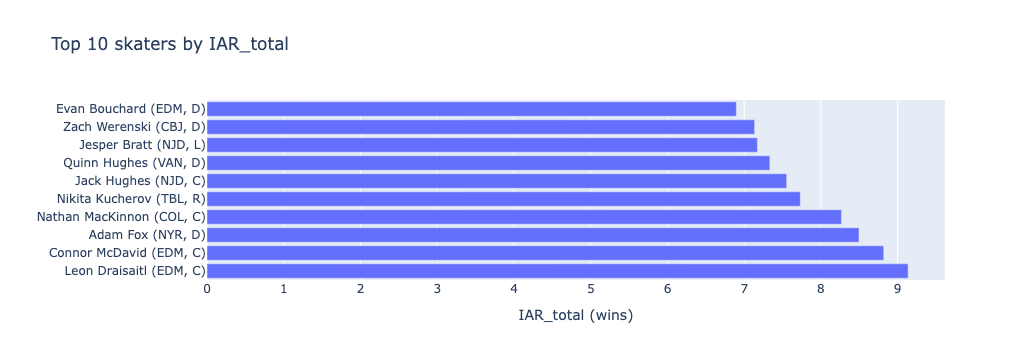

In [188]:
# Defining plotting function
def bar_iar_total(df_subset, title, category_order):
    d = df_subset.copy()

    fig = px.bar(
        d,
        y="label",
        x="IAR_total",
        orientation="h",
        title=title,
        hover_data={"team": True, "position": True, "min_5v5": True, "IAR_total":":.2f"},
        category_orders={"label": category_order}
    )
    fig.update_layout(xaxis_title="IAR_total (wins)", yaxis_title="")
    return fig

fig0_top = bar_iar_total(top10, "Top 10 skaters by IAR_total", top_order)
fig0_top.show()


## 1. Stacked horizontal bars (composition: 5v5 vs PP vs PK)


In [204]:
# Defining plotting function
def stacked_bar(df_subset, title, category_order):
    plot_df = df_subset.melt(
        id_vars=["label", "team", "position", "min_5v5", "IAR_total"],
        value_vars=["IAR_5v5", "IAR_PP", "IAR_PK"],
        var_name="component",
        value_name="IAR_wins",
    )

    fig = px.bar(
        plot_df,
        y="label",
        x="IAR_wins",
        color="component",
        orientation="h",
        title=title,
        hover_data={"team": True, "position": True, "min_5v5": True, "IAR_total": True, "IAR_wins":":.2f"},
        category_orders={"label": category_order}
    )
    fig.update_layout(barmode="stack", xaxis_title="IAR (wins)", yaxis_title="")
    return fig



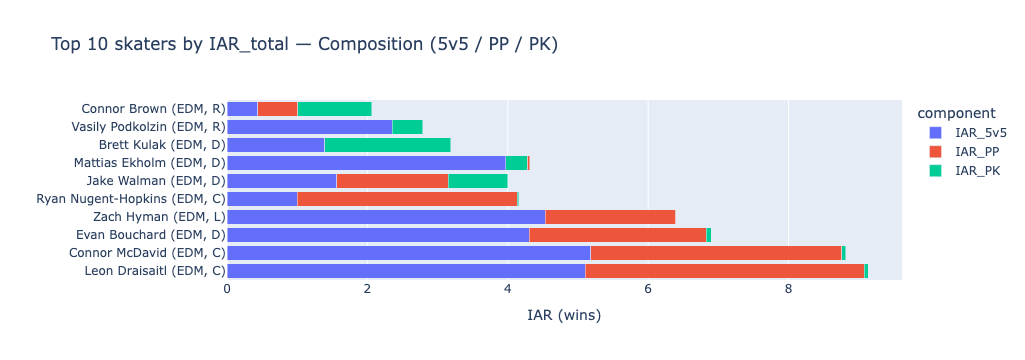

In [206]:
# Oilers colours

fig1_oilers = stacked_bar(top10_oilers, "Top 10 skaters by IAR_total — Composition (5v5 / PP / PK)", top_order_oilers)
fig1_oilers.show()

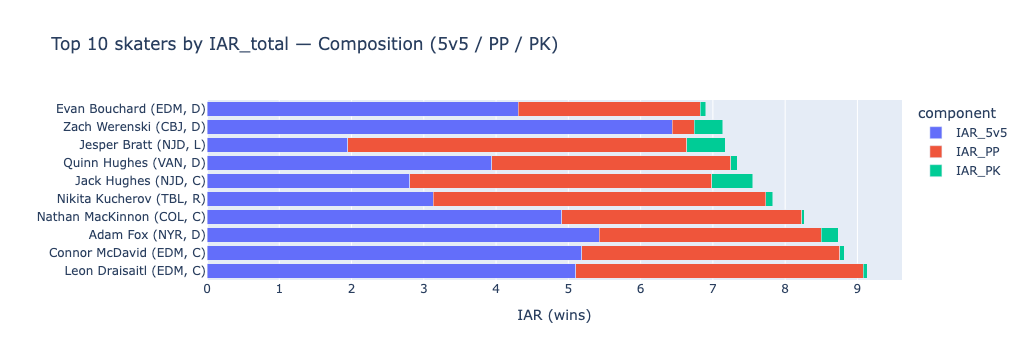

In [139]:
fig1_top = stacked_bar(top10, "Top 10 skaters by IAR_total — Composition (5v5 / PP / PK)", top_order)
fig1_top.show()


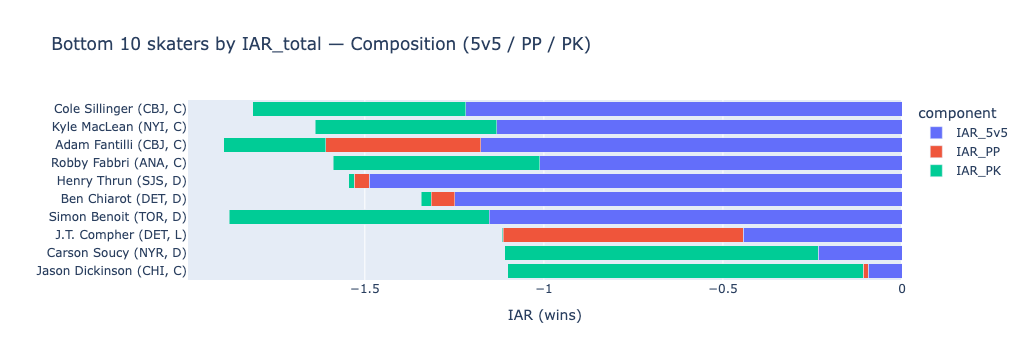

In [141]:
fig1_bot = stacked_bar(bot10, "Bottom 10 skaters by IAR_total — Composition (5v5 / PP / PK)", bot_order)
fig1_bot.show()

**Interpretation**:
This figure decomposes the top 10 and bottom 10 skaters by IAR_total into their underlying components (5v5, PP, PK), showing whether each player’s 
overall impact is driven primarily by even-strength play or by special-teams contributions. The “so what” is that it distinguishes true 5v5 drivers
(more transferable and stable) from players whose value is role- or usage-dependent on special teams, and it shows that the bottom group is typically
negative because of a large 5v5 deficit that special teams rarely offset.

## 2. Quadrant scatter: 5v5 backbone vs special teams

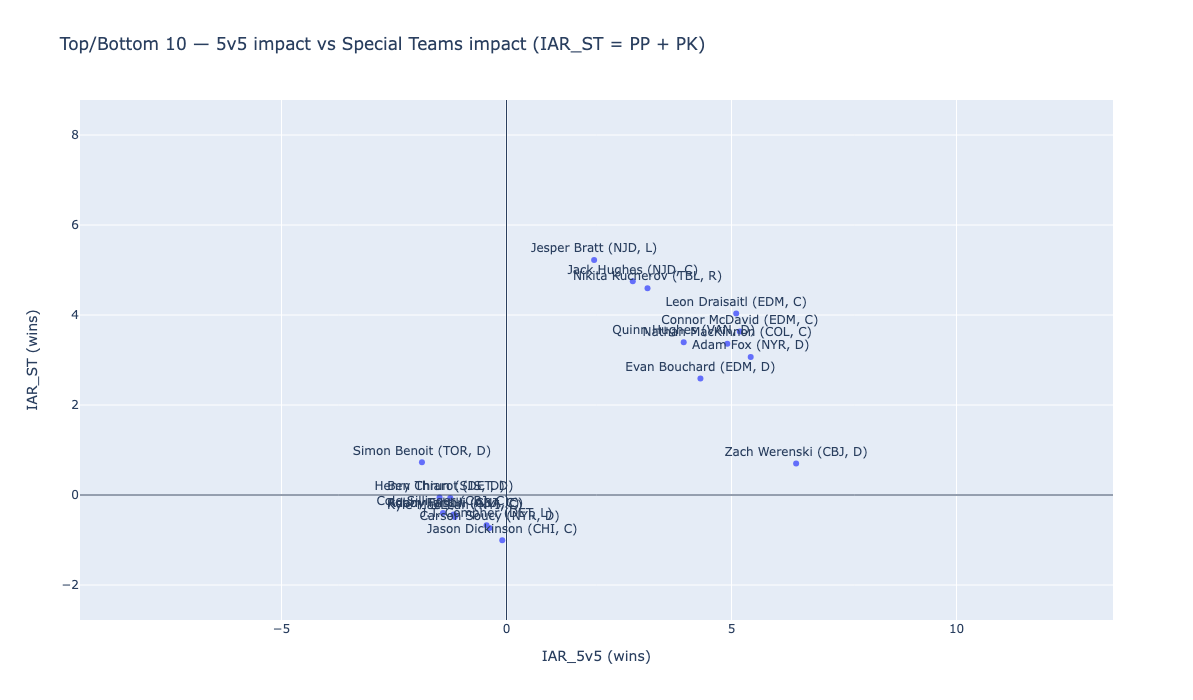

In [158]:
fig2 = px.scatter(
    tb,
    x="IAR_5v5",
    y="IAR_ST",
    text="label",
    hover_data={"team": True, "position": True, "min_5v5": True, "IAR_total":":.2f"},
    title="Top/Bottom 10 — 5v5 impact vs Special Teams impact (IAR_ST = PP + PK)",
)

# Optional quadrant reference lines at 0
fig2.add_vline(x=0, line_width=1)
fig2.add_hline(y=0, line_width=1)

# Capping axes limits
fig2.update_xaxes(range=[-4, 8])
fig2.update_yaxes(range=[-2, 8], scaleanchor="x", scaleratio=1)

fig2.update_layout(width=700, height=700)  # square canvas

# Make labels readable
fig2.update_traces(textposition="top center")
fig2.update_layout(xaxis_title="IAR_5v5 (wins)", yaxis_title="IAR_ST (wins)")

fig2.show()

**Interpretation:** 
This figure positions the top and bottom skaters by their even-strength impact (IAR_5v5) versus their special teams impact (IAR_ST = PP + PK),
separating “true 5v5 drivers” from players whose value is concentrated on special teams. The “so what” is that two players can arrive at a similar
IAR_total through very different pathways—useful for roster construction and deployment—while the bottom group clusters in the negative 5v5 region, 
indicating that weak even-strength impact is typically the binding constraint that special teams rarely offset.

## 2.2) Goalies vs Minutes

In [209]:
g.head()

,playerId,name,team,min_5v5,IAR_5v5,IAR_xg,min_PP,IAR_PP,min_PK,IAR_PK,IAR_total
0,8470594,Marc-Andre Fleury,MIN,1171.533333,-0.151714,-0.910284,99.483333,0.098157,82.400000,-0.323109,-0.376666
1,8471734,Jonathan Quick,NYR,1129.850000,0.239646,1.437874,85.016667,-0.067086,74.833333,0.277655,0.450215
2,8473503,James Reimer,BUF,1125.116667,1.803060,10.818360,96.466667,0.163312,99.416667,0.058891,2.025263
3,8473575,Semyon Varlamov,NYI,509.866667,0.790326,4.741956,59.250000,0.167431,25.433333,-0.539000,0.418756
4,8474593,Jacob Markstrom,NJD,2427.216667,0.924391,5.546345,181.600000,0.526349,228.050000,1.547567,2.998307


In [215]:
# Load your output table
g = pd.read_csv("iar_goalies_2024_poc.csv")

# Basic cleanup / engineered fields
g["IAR_ST"] = g["IAR_PP"].fillna(0) + g["IAR_PK"].fillna(0)  # special teams
g["label"] = g["name"] + " (" + g["team"].astype(str) + ", " + "G)"

# Recommended filter for stable leaderboards
MIN_5V5_MIN = 600
gq = g[g["min_5v5"] >= MIN_5V5_MIN].copy()

# Getting only oilers
gq_oilers = gq.loc[gq['team'] == 'EDM']

# Top / bottom 10 by total impact
top10_g = gq.nlargest(10, "IAR_total").copy()
bot10_g = gq.nsmallest(10, "IAR_total").copy()
top10_oilers_g = gq_oilers.nlargest(10, "IAR_total").copy()

# Combined set for “top vs bottom” visuals
tbg = pd.concat([top10.assign(group="Top 10"), bot10.assign(group="Bottom 10")], ignore_index=True)

# Helpful ordering for plots
top_order_g = top10.sort_values("IAR_total", ascending=True)["label"].tolist()   # ascending for horizontal bars
bot_order_g = bot10.sort_values("IAR_total", ascending=True)["label"].tolist()
top_order_oilers_g = top10_oilers.sort_values("IAR_total", ascending=True)["label"].tolist()   # ascending for horizontal bars


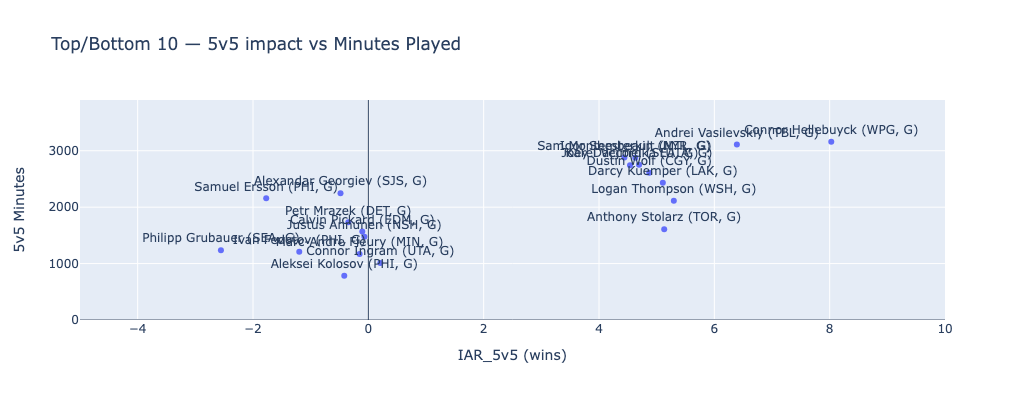

In [261]:
fig2_2 = px.scatter(
    tbg,
    x="IAR_5v5",
    y="min_5v5",
    text="label",
    hover_data={"team": True, "min_5v5": True, "IAR_total":":.2f"},
    title="Top/Bottom 10 — 5v5 impact vs Minutes Played",
)

# Optional quadrant reference lines at 0
fig2_2.add_vline(x=0, line_width=1)
fig2_2.add_hline(y=0, line_width=1)

# Capping axes limits
fig2_2.update_xaxes(range=[-5, 10])
fig2_2.update_yaxes(range=[0, 3900])

fig2_2.update_layout(width=700, height=400)  # square canvas

# Make labels readable
fig2_2.update_traces(textposition="top center")
fig2_2.update_layout(xaxis_title="IAR_5v5 (wins)", yaxis_title="5v5 Minutes")

fig2_2.show()

## 3. Lollipop chart with TOI cue (point size = 5v5 minutes)


In [88]:
# Plotting functions

def lollipop(df_subset, title, ascending=True):
    d = df_subset.sort_values("IAR_total", ascending=ascending).copy()

    fig = go.Figure()

    # Stems
    for _, r in d.iterrows():
        fig.add_trace(go.Scatter(
            x=[0, r["IAR_total"]],
            y=[r["label"], r["label"]],
            mode="lines",
            showlegend=False,
            hoverinfo="skip",
        ))

    # Points (size encodes minutes)
    # Scale sizes to a reasonable range
    mins = d["min_5v5"].astype(float)
    size = 10 + 30 * (mins - mins.min()) / (mins.max() - mins.min() + 1e-9)

    fig.add_trace(go.Scatter(
        x=d["IAR_total"],
        y=d["label"],
        mode="markers",
        marker=dict(size=size),
        text=d["label"],
        hovertemplate=(
            "<b>%{y}</b><br>"
            "IAR_total=%{x:.2f}<br>"
            "5v5 minutes=%{customdata[0]:.0f}<br>"
            "IAR_5v5=%{customdata[1]:.2f}<br>"
            "IAR_PP=%{customdata[2]:.2f}<br>"
            "IAR_PK=%{customdata[3]:.2f}<extra></extra>"
        ),
        customdata=np.stack([d["min_5v5"], d["IAR_5v5"], d["IAR_PP"], d["IAR_PK"]], axis=1),
        showlegend=False,
    ))

    fig.update_layout(
        title=title,
        xaxis_title="IAR_total (wins)",
        yaxis_title="",
    )
    return fig


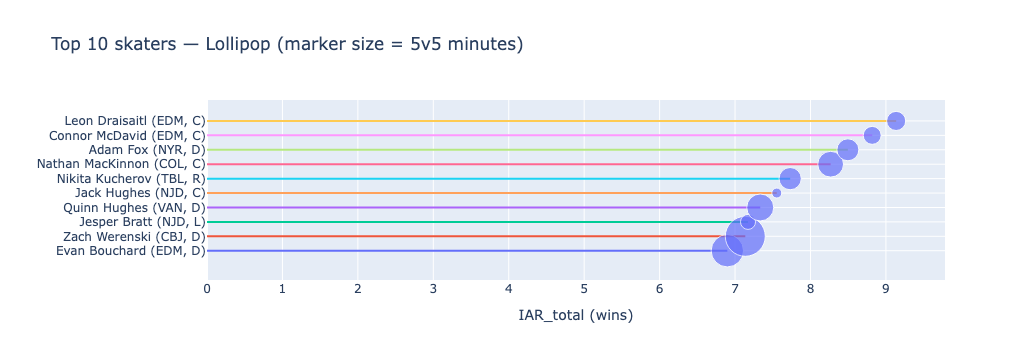

In [95]:
fig3_top = lollipop(top10, "Top 10 skaters — Lollipop (marker size = 5v5 minutes)", ascending=True)
fig3_top.show()


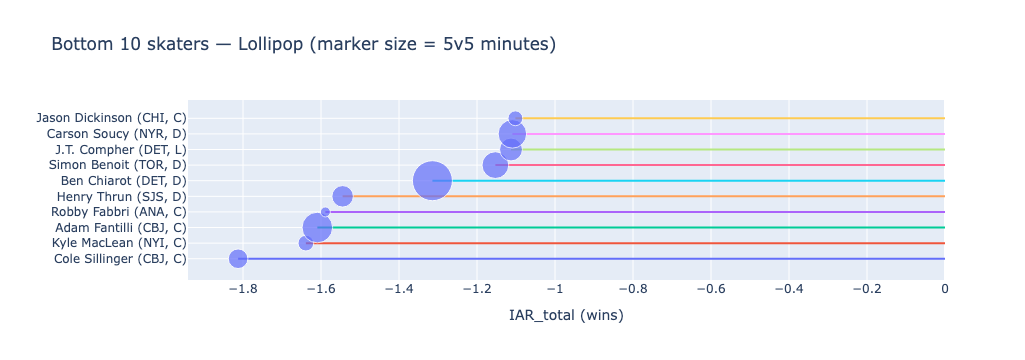

In [97]:
fig3_bot = lollipop(bot10, "Bottom 10 skaters — Lollipop (marker size = 5v5 minutes)", ascending=True)
fig3_bot.show()

**Interpretation**: 
This lollipop chart ranks the top 10 and bottom 10 skaters by IAR_total, while using marker size to encode 5v5 minutes 
as a quick proxy for how much evidence backs each estimate. The “so what” is that it helps separate high-impact performance 
sustained over heavy 5v5 usage from smaller-minute extremes, and it also shows that the negative tail is relatively 
tight (clustered near 0 to about −2 wins), suggesting fewer truly catastrophic results once you apply a minutes-qualified filter.


## 4. Bubble plot: impact vs cost (AAV), with top/bottom labels

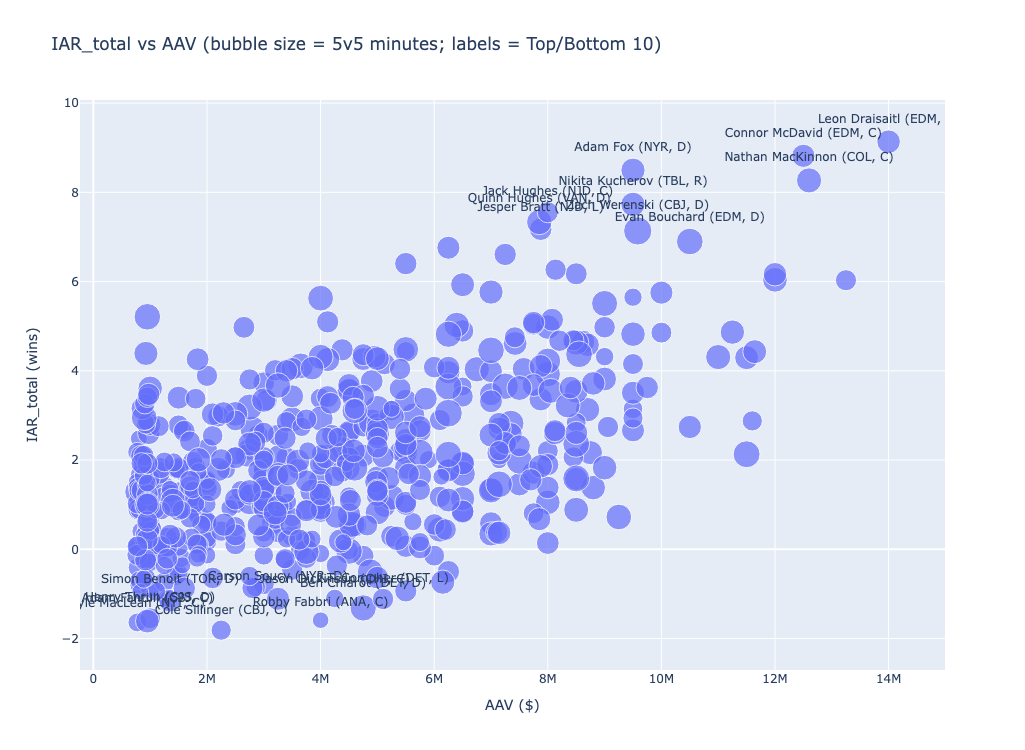

In [174]:
df_cost = skq[skq["AAV_num"].notna() & (skq["AAV_num"] > 0)].copy()

# Label only top/bottom 10 to keep it readable
df_cost["is_tb"] = df_cost["label"].isin(tb["label"])
df_cost["text_label"] = np.where(df_cost["is_tb"], df_cost["label"], "")

fig4 = px.scatter(
    df_cost,
    x="AAV_num",
    y="IAR_total",
    size="min_5v5",
    hover_data={"team": True, "position": True, "min_5v5": True, "IAR_5v5":":.2f", "IAR_PP":":.2f", "IAR_PK":":.2f"},
    text="text_label",
    title="IAR_total vs AAV (bubble size = 5v5 minutes; labels = Top/Bottom 10)"
)


fig4.update_layout(width=750, height=750)  # square canvas

fig4.update_traces(textposition="top center")
fig4.update_layout(xaxis_title="AAV ($)", yaxis_title="IAR_total (wins)")
fig4.show()

**Interpretation**:
This bubble plot benchmarks on-ice impact (IAR_total) against contract cost (AAV), with bubble size 
capturing 5v5 usage to distinguish heavily deployed regulars from smaller-role players. The “so what” is 
it surfaces where the league is getting surplus value (high impact at low/mid AAV) versus where contracts 
appear misaligned with impact (high AAV with modest or negative IAR), while keeping in mind that ELC/low-AAV 
deals naturally look favorable on a per-dollar basis.

## 5. Team context mini-panels (small multiples)


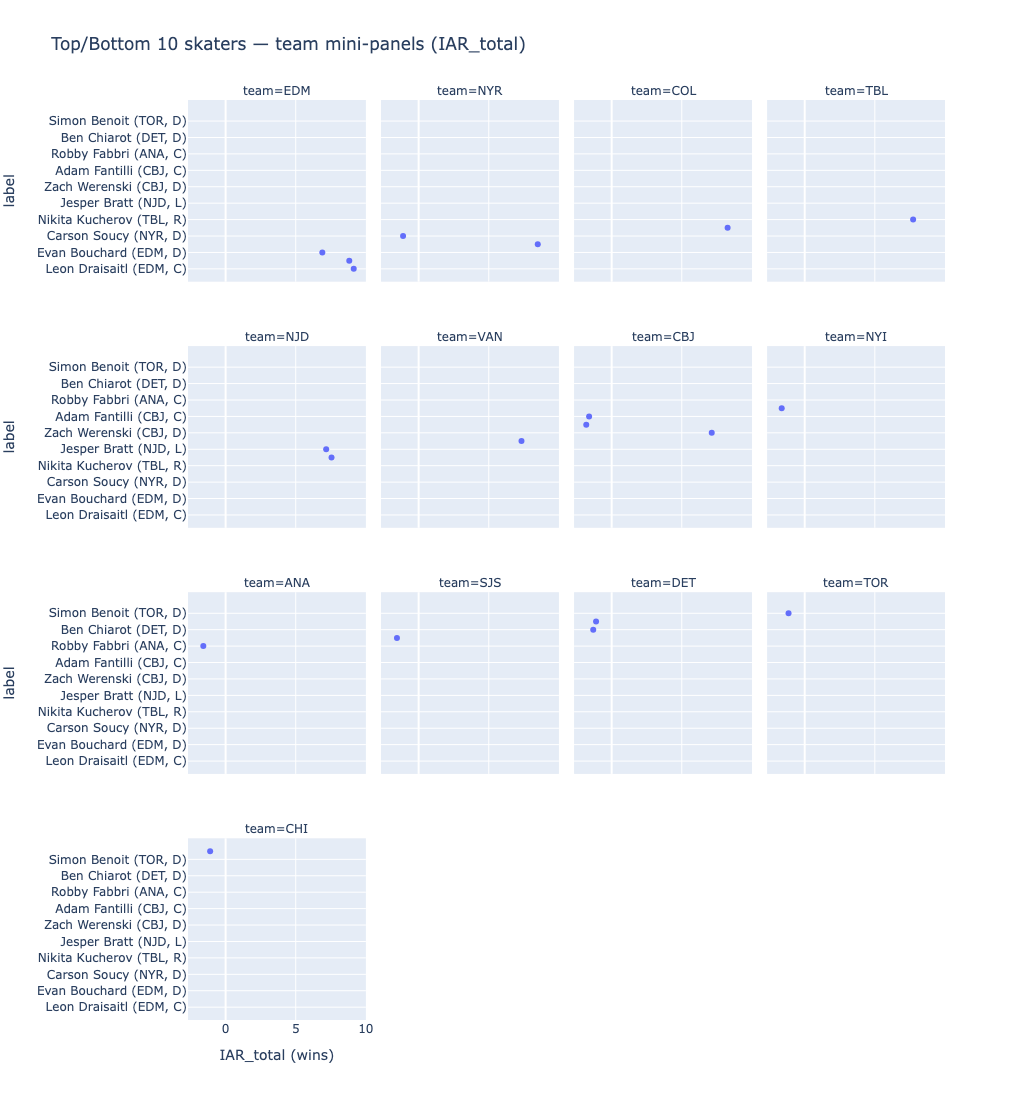

In [133]:
tb_team = tb.copy()
tb_team["IAR_ST"] = tb_team["IAR_PP"] + tb_team["IAR_PK"]

fig5 = px.scatter(
    tb_team,
    x="IAR_total",
    y="label",
    facet_col="team",
    facet_col_wrap=4,  # adjusts layout based on number of teams in the top/bottom set
    title="Top/Bottom 10 skaters — team mini-panels (IAR_total)",
    hover_data={"position": True, "min_5v5": True, "IAR_5v5":":.2f", "IAR_ST":":.2f"},
)

# Add a reference line at 0 in each facet (Plotly won't auto-repeat vlines per facet easily;
# easiest is to keep it as an interpretive note, or add after if you want more custom layout.)
fig5.update_layout(xaxis_title="IAR_total (wins)", yaxis_title="")
fig5.update_layout(width=1100, height=1100)  # square canvas

fig5.show()

**Interpretation**
This figure breaks the top/bottom skaters into team-specific mini-panels, showing whether extreme IAR_total 
outcomes are isolated to single players or cluster within certain teams. The “so what” is that clustering can 
be a red flag for team context effects (system, usage, roster quality) influencing on/off estimates, while 
teams appearing on both extremes (e.g., multiple top skaters but also bottom skaters) can indicate high-variance 
deployment or uneven roster contributions that merit deeper review.